###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018  by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

###### Translated by Huizhe Di @ SCSIO

# 二维声学有限差分建模代码的性能优化

在 [上节课中](http://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/05_2D_acoustic_FD_modelling/1_From_1D_to_2D_acoustic_FD_modelling_final.ipynb), 在一维代码的基础上，开发二维声学有限差分代码只花了15分钟。然而，由于运行时大约为3分钟，这个“普通的”Python实现的性能相当不理想。因此，本课的目的是优化此代码的性能。

让我们从对原始代码稍加修改的版本开始。基本上，我把解析解的计算移出了主代码，离散化参数 $nx,\; nz,\; nt,\; dx,\; dz,\; dt$ 也是固定的，以减少对FD建模功能的输入.

In [2]:
# Import Libraries 
# ----------------
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Definition of modelling parameters
# ----------------------------------
xmax = 500.0 # maximum spatial extension of the 1D model in x-direction (m)
zmax = xmax  # maximum spatial extension of the 1D model in z-direction(m)
dx   = 1.0   # grid point distance in x-direction
dz   = dx    # grid point distance in z-direction

tmax = 0.502   # maximum recording time of the seismogram (s)
dt   = 0.0010  # time step

vp0  = 580.   # P-wave speed in medium (m/s)

# acquisition geometry
xr = 330.0 # x-receiver position (m)
zr = xr    # z-receiver position (m)

xsrc = 250.0 # x-source position (m)
zsrc = 250.0 # z-source position (m)

f0   = 40. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift (s)

In [4]:
# define model discretization
# ---------------------------

nx = (int)(xmax/dx) # number of grid points in x-direction
print('nx = ',nx)

nz = (int)(zmax/dz) # number of grid points in x-direction
print('nz = ',nz)

nt = (int)(tmax/dt) # maximum number of time steps            
print('nt = ',nt)

ir = (int)(xr/dx)      # receiver location in grid in x-direction    
jr = (int)(zr/dz)      # receiver location in grid in z-direction

isrc = (int)(xsrc/dx)  # source location in grid in x-direction
jsrc = (int)(zsrc/dz)  # source location in grid in x-direction

# Source time function (Gaussian)
# -------------------------------
src  = np.zeros(nt + 1)
time = np.linspace(0 * dt, nt * dt, nt)

# 1st derivative of a Gaussian
src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))

# Analytical solution
# -------------------
G    = time * 0.

# Initialize coordinates
# ----------------------
x    = np.arange(nx)
x    = x * dx       # coordinates in x-direction (m)

z    = np.arange(nz)
z    = z * dz       # coordinates in z-direction (m)

# calculate source-receiver distance
r = np.sqrt((x[ir] - x[isrc])**2 + (z[jr] - z[jsrc])**2)

for it in range(nt): # Calculate Green's function (Heaviside function)
    if (time[it] - r / vp0) >= 0:
        G[it] = 1. / (2 * np.pi * vp0**2) * (1. / np.sqrt(time[it]**2 - (r/vp0)**2))
Gc   = np.convolve(G, src * dt)
Gc   = Gc[0:nt]
lim  = Gc.max() # get limit value from the maximum amplitude

# Initialize model (assume homogeneous model)
# -------------------------------------------
vp    = np.zeros((nx,nz))
vp2    = np.zeros((nx,nz))

vp  = vp + vp0       # initialize wave velocity in model
vp2 = vp**2

nx =  500
nz =  500
nt =  502


In [5]:
# 2D Wave Propagation (Finite Difference Solution) 
# ------------------------------------------------
def FD_2D_acoustic_vanilla():        
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros((nx,nz)) # p at time n (now)
    pold = np.zeros((nx,nz)) # p at time n-1 (past)
    pnew = np.zeros((nx,nz)) # p at time n+1 (present)
    d2px = np.zeros((nx,nz)) # 2nd spatial x-derivative of p
    d2pz = np.zeros((nx,nz)) # 2nd spatial z-derivative of p

    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros(nt) 
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):
    
        # FD approximation of spatial derivative by 3 point operator
        for i in range(1, nx - 1):
            for j in range(1, nz - 1):
                
                d2px[i,j] = (p[i + 1,j] - 2 * p[i,j] + p[i - 1,j]) / dx ** 2                
                d2pz[i,j] = (p[i,j + 1] - 2 * p[i,j] + p[i,j - 1]) / dz ** 2

        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp ** 2 * dt ** 2 * (d2px + d2pz)

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc,jsrc] = pnew[isrc,jsrc] + src[it] / (dx * dz) * dt ** 2
                
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
    
        # Output of Seismogram
        # -----------------
        seis[it] = p[ir,jr]

你知道上次发生了什么，我们执行了下面的单元格。我们必须等3分钟，直到模型运行结束。因此，出于安全考虑，我注释了代码执行并定义了运行时。 您应该根据您的计算机的值调整时间测量值 `t_vanilla_python` 的值.

In [6]:
# %%time
# FD_2D_acoustic_vanilla()
t_vanilla_python = 109.0

## 即时 (Just-In-Time, JIT) 代码编译通过Numba 

普通Python代码的糟糕性能是由于用于计算二次空间有限差分导数的嵌套FOR循环。 我们可以使用 `Numba ` 库来进行优化 ([http://numba.pydata.org/](http://numba.pydata.org/)) 将Python函数转换为c风格的编译函数使用 [LLVM](https://en.wikipedia.org/wiki/LLVM). Gil Forsyth和Lorena Barba在2016年SciPy大会上介绍了Numba 

**Numba: Tell those C++ bullies to get lost**

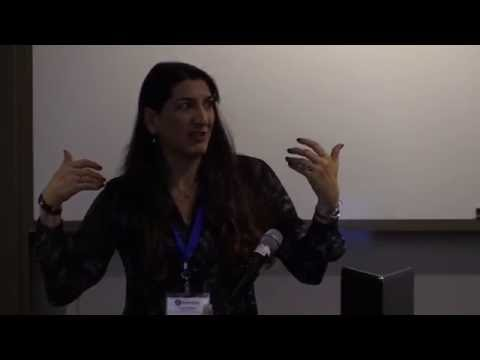

In [7]:
from IPython.display import YouTubeVideo
YouTubeVideo('SzBi3xdEF2Y')

相关的Jupyter notebooks 在这里[here](https://github.com/barbagroup/numba_tutorial_scipy2016).

首先, 我们需要安装 Numba: 

`conda install numba` 

从 Numba 库中，我们导入 **jit**: 

In [8]:
# import JIT from Numba
from numba import jit

我们在原始Python代码中唯一修改的是添加函数装饰器 

`@jit(nopython=True)`

标记函数 `FD_2D_acoustic_JIT` 将会被编译:

In [9]:
# FD_2D_acoustic code with JIT optimization
# -----------------------------------------
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance 仅添加这一行代码
def FD_2D_acoustic_JIT():        
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros((nx,nz)) # p at time n (now)
    pold = np.zeros((nx,nz)) # p at time n-1 (past)
    pnew = np.zeros((nx,nz)) # p at time n+1 (present)
    d2px = np.zeros((nx,nz)) # 2nd spatial x-derivative of p
    d2pz = np.zeros((nx,nz)) # 2nd spatial z-derivative of p

    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros(nt) 
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):
    
        # FD approximation of spatial derivative by 3 point operator
        for i in range(1, nx - 1):
            for j in range(1, nz - 1):
                
                d2px[i,j] = (p[i + 1,j] - 2 * p[i,j] + p[i - 1,j]) / dx**2                
                d2pz[i,j] = (p[i,j + 1] - 2 * p[i,j] + p[i,j - 1]) / dz**2

        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp2 * dt**2 * (d2px + d2pz)

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc,jsrc] = pnew[isrc,jsrc] + src[it] / (dx * dz) * dt ** 2
                
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
    
        # Output of Seismogram
        # -----------------
        seis[it] = p[ir,jr]   
        
    return seis

Let's run the code:

In [10]:
%%time
seis_FD_JIT = FD_2D_acoustic_JIT()

CPU times: user 799 ms, sys: 72 ms, total: 871 ms
Wall time: 934 ms


哇，你不用等3分钟，但只要747毫秒。再次运行上面的单元格 ...

... 你可以看到运行时间突然进一步减少到373毫秒。这种性能改进可以通过代码第一次运行时的代码编译来解释
因此，通过简单地使用' @jit '函数装饰器，与未优化的Python代码相比，我们获得了 **509倍** 的性能提升。

In [11]:
t_JIT_python = 0.373  # runtime of JIT compiled Python code (s)

消除嵌套for循环的另一种方法是使用Numpy数组操作:

In [12]:
# FD_2D_acoustic code with NumPy arrays
# -------------------------------------
def FD_2D_acoustic_numpy():        
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros((nx,nz)) # p at time n (now)
    pold = np.zeros((nx,nz)) # p at time n-1 (past)
    pnew = np.zeros((nx,nz)) # p at time n+1 (present)
    d2px = np.zeros((nx,nz)) # 2nd spatial x-derivative of p
    d2pz = np.zeros((nx,nz)) # 2nd spatial z-derivative of p

    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros(nt) 
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):    

        # Old FD approximation of spatial derivative by 3-point operator
        # using nested FOR-loops is replaced by ...
        #for i in range(1, nx - 1):
        #    for j in range(1, nz - 1):
        #        
        #        d2px[i,j] = (p[i + 1,j] - 2 * p[i,j] + p[i - 1,j]) / dx**2                
        #        d2pz[i,j] = (p[i,j + 1] - 2 * p[i,j] + p[i,j - 1]) / dz**2
        
        # ... Numpy array operations:
        d2px[1:-2,1:-2] = (p[2:-1,1:-2] - 2 * p[1:-2,1:-2] + p[0:-3,1:-2]) / dx**2
        d2pz[1:-2,1:-2] = (p[1:-2,2:-1] - 2 * p[1:-2,1:-2] + p[1:-2,0:-3]) / dz**2
        
        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp ** 2 * dt ** 2 * (d2px + d2pz)

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc,jsrc] = pnew[isrc,jsrc] + src[it] / (dx * dz) * dt ** 2
                
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
    
        # Output of Seismogram
        # -----------------
        seis[it] = p[ir,jr]   
        
    return seis

In [13]:
%%time
seis_FD_numpy = FD_2D_acoustic_numpy()

CPU times: user 767 ms, sys: 408 ms, total: 1.17 s
Wall time: 1.18 s


In [14]:
t_numpy_python = 1.93  # runtime of JIT compiled Python code (s)

运行时间 1.93 s `NumPy` 版本并没有JIT版本的 0.373 s 的快, 但是 **98倍** 的提升也远好于没有优化的版本。JIT能够提高 `FD_2D_acoustic_numpy` 版本吗?

In [15]:
# FD_2D_acoustic code with NumPy arrays + JIT
# -------------------------------------------
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance 
def FD_2D_acoustic_numpy_JIT():        
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros((nx,nz)) # p at time n (now)
    pold = np.zeros((nx,nz)) # p at time n-1 (past)
    pnew = np.zeros((nx,nz)) # p at time n+1 (present)
    d2px = np.zeros((nx,nz)) # 2nd spatial x-derivative of p
    d2pz = np.zeros((nx,nz)) # 2nd spatial z-derivative of p

    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros(nt) 
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):    

        # Old FD approximation of spatial derivative by 3-point operator
        # using Numpy array operations
        d2px[1:-2,1:-2] = (p[2:-1,1:-2] - 2 * p[1:-2,1:-2] + p[0:-3,1:-2]) / dx**2
        d2pz[1:-2,1:-2] = (p[1:-2,2:-1] - 2 * p[1:-2,1:-2] + p[1:-2,0:-3]) / dz**2
        
        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp ** 2 * dt ** 2 * (d2px + d2pz)

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc,jsrc] = pnew[isrc,jsrc] + src[it] / (dx * dz) * dt ** 2
                
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
    
        # Output of Seismogram
        # -----------------
        seis[it] = p[ir,jr]   
        
    return seis

In [16]:
%%time
seis_FD_numpy_JIT = FD_2D_acoustic_numpy_JIT()

CPU times: user 824 ms, sys: 125 ms, total: 948 ms
Wall time: 948 ms


In [17]:
t_numpy_python_JIT = 0.481  # runtime of JIT compiled Python code (s)

因此，JIT也可以提高使用 `NumPy` 数组操作的代码的性能，但使用嵌套FOR循环的编译代码的性能在性能方面略有优势。 

## 与C++实现的比较

JIT代码的性能与C++代码相比如何? 我花了一个小时来写 [this C++ code](https://github.com/daniel-koehn/Theory-of-seismic-waves-II/tree/master/05_2D_acoustic_FD_modelling/cxx/2dac.cpp), 类似于2D声学有限差分的Python代码. 

为了在C++中使用与Python中相似的矩阵数据结构, 我使用了 `Eigen` 库:

www.eigen.tuxfamily.org/

这也允许矩阵-矩阵乘积的自动向量化。要编译源代码，你需要一个C++编译器。' g++ '和' Eigen '库，它们既可以从源代码编译，也可以使用Linux发行版的包管理器安装。

我还建议使用适度优化选项 `-O2` 和高级向量扩展 ([AVX](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions)) `-mavx` 在代码编译期间显著提高了代码的性能. 让我们编译和实现它:

In [18]:
# Compile and run C++-version
# In Mac OS
!g++ -I /opt/homebrew/Cellar/eigen/3.4.0_1/include/eigen3 cxx/2dac.cpp -o 2dac -O2 
!./2dac

# load seismogram
time_Cpp, seis_FD_Cpp = np.loadtxt('seis.dat', delimiter='\t', skiprows=0, unpack=True)

Wall time: 237.193 ms


In [21]:
t_cxx = 0.432  # runtime of C++ code (s)

C++代码的性能可以与使用 `NumPy` 作的Python代码的JIT版本相媲美，考虑到使用JIT进行简单的Python代码优化，这是相当令人印象深刻的。


为了检查优化代码是否不仅速度快而且仍然产生合理的建模结果，检查优化代码的地震图是否仍然与解析解一致是一个好主意。

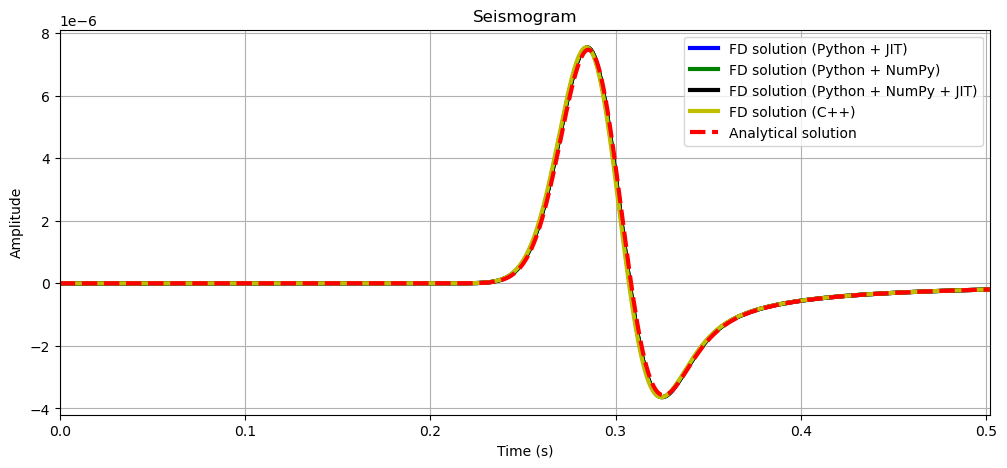

In [22]:
# Compare FD Seismogram with analytical solution
# ----------------------------------------------
# Define figure size
rcParams['figure.figsize'] = 12, 5
plt.plot(time, seis_FD_JIT, 'b-',lw=3,label="FD solution (Python + JIT)") # plot FD seismogram
plt.plot(time, seis_FD_numpy, 'g-',lw=3,label="FD solution (Python + NumPy)") # plot FD seismogram
plt.plot(time, seis_FD_numpy_JIT, 'k-',lw=3,label="FD solution (Python + NumPy + JIT)") # plot FD seismogram
plt.plot(time_Cpp, seis_FD_Cpp, 'y-',lw=3,label="FD solution (C++)") # plot FD seismogram
Analy_seis = plt.plot(time,Gc,'r--',lw=3,label="Analytical solution") # plot analytical solution
plt.xlim(time[0], time[-1])
plt.title('Seismogram')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show() 

最后，我们制作了一些漂亮的柱状图来比较在这款 'Jupyter' 笔记本中开发的不同代码的性能:

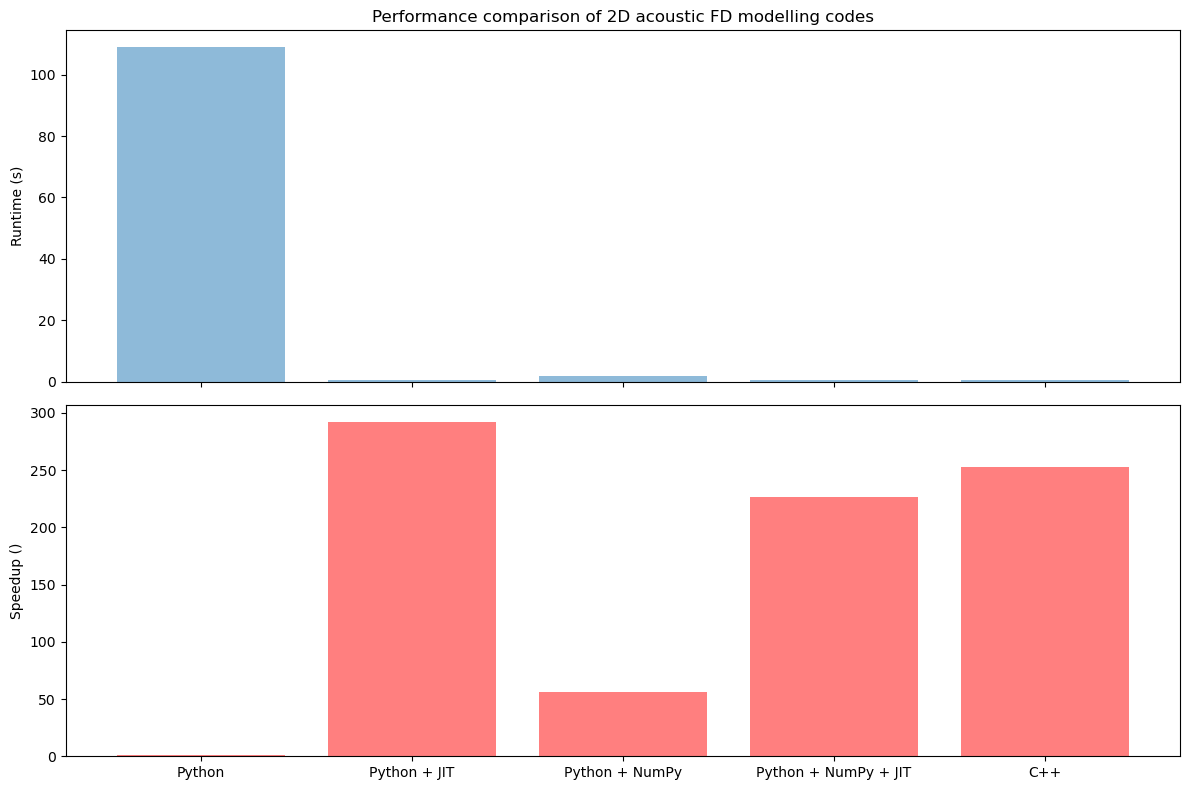

In [23]:
# define codes
codes = ('Python', 'Python + JIT', 'Python + NumPy', 'Python + NumPy + JIT', 'C++')
y_pos = np.arange(len(codes))

# runtime
performance = [t_vanilla_python,t_JIT_python,t_numpy_python,t_numpy_python_JIT,t_cxx]

# speed-up with respect to the non-optimized code
speedup = [t_vanilla_python/t_vanilla_python,
           t_vanilla_python/t_JIT_python,
           t_vanilla_python/t_numpy_python,
           t_vanilla_python/t_numpy_python_JIT,
           t_vanilla_python/t_cxx]

# Define figure size
rcParams['figure.figsize'] = 12, 8

# Plot runtimes of 2D acoustic FD codes
ax1 = plt.subplot(211)

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, codes)
plt.ylabel('Runtime (s)')
plt.title('Performance comparison of 2D acoustic FD modelling codes')
 
# make tick labels invisible
plt.setp(ax1.get_xticklabels(), visible=False)   

# Plot speedup of 2D acoustic FD codes
ax2 = plt.subplot(212, sharex=ax1)    

plt.bar(y_pos, speedup, align='center', alpha=0.5,color='r')
plt.xticks(y_pos, codes)
plt.ylabel('Speedup ()')
plt.tight_layout() 
plt.show()

这是我们所能达到的最佳结果吗? 还是有可能进一步改进代码? 

使用域分解和 **Message-Passing Interface MPI** 将工作负载分布到多个CPU核上, 结合使用 **Multithreading** 在每个域中划分任务，可以显著提高代码性能. 一个关键是手动优化CPU和GPU内核，特别是关于内存访问时间或MPI进程之间的通信。作为一个例子，我使用二维声学建模代码从这个Jupyter笔记本上绘制了相同均匀声学问题的运行时间和加速 [DENISE Black-Edition](https://github.com/daniel-koehn/DENISE-Black-Edition) 这仅仅依赖于 MPI:

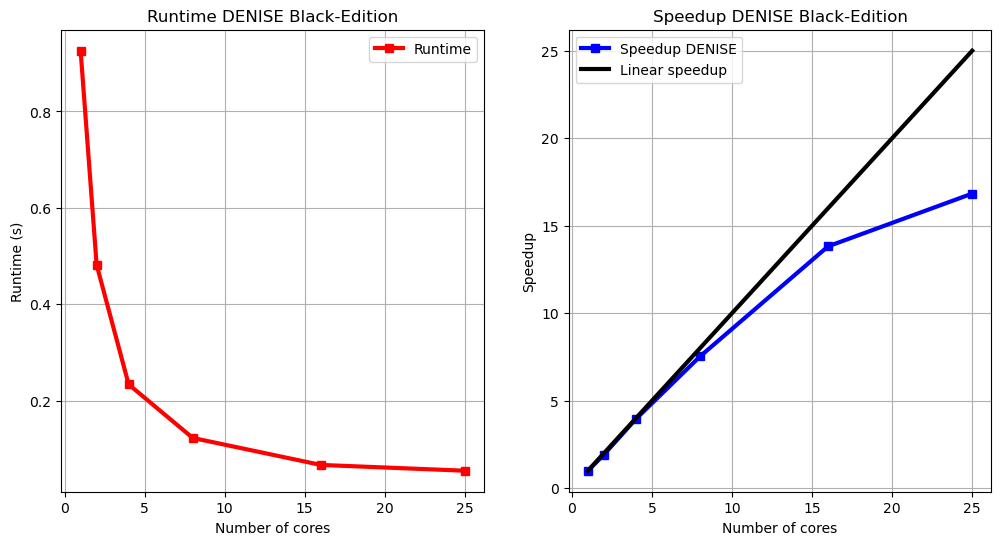

In [25]:
# Define figure size
rcParams['figure.figsize'] = 12, 6

# number of cores and runtime
cores = np.array([1, 2, 4, 8, 16, 25])
t_denise = np.array([0.926, 0.482, 0.234, 0.123, 0.067, 0.055])

# speed-up with respect to the runtime of the 1st core
# and linear speedup
speedup_denise = t_denise[0] / t_denise
linear_speedup = cores

# plot runtime
ax2 = plt.subplot(121)
plt.plot(cores, t_denise, 'rs-',lw=3,label="Runtime")
plt.title('Runtime DENISE Black-Edition')
plt.xlabel('Number of cores')
plt.ylabel('Runtime (s)')
plt.legend()
plt.grid()

# plot speedup
ax2 = plt.subplot(122)
plt.plot(cores, speedup_denise, 'bs-',lw=3,label="Speedup DENISE")
plt.plot(cores, linear_speedup, 'k-',lw=3,label="Linear speedup")
plt.title('Speedup DENISE Black-Edition')
plt.xlabel('Number of cores')
plt.ylabel('Speedup')
plt.legend()
plt.grid()

plt.show() 

JIT编译的Python代码使用不到2个内核，运行时为353毫秒，比MPI代码快。利用更多的核心，DENISE代码导致运行时的稳定下降。然而，请注意，当使用16核或更多核时，加速不再是线性的。这可以解释为，当域大小减小时，MPI进程之间的通信时间过长。关于MPI和多线程优化的更多细节超出了TEW2课程的范围，但将是未来HPC课程的主题 ...

为了进一步了解JIT优化的Python代码和手动优化的代码之间的区别, 我推荐Andreas Klöckner的SciPy 2016 talk:


**High Performance with Python: Architectures, Approaches & Applications**

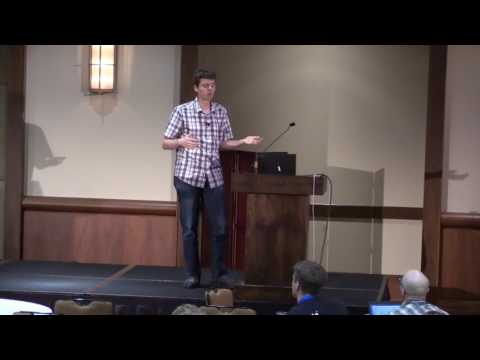

In [26]:
from IPython.display import YouTubeVideo
YouTubeVideo('Zz_6P5qAJck')

## 我们学习到:

* 我们在上节课中开发的二维声学有限差分建模代码的性能受到嵌套FOR循环的影响
* 使用“Numba”对Python代码进行JIT编译，性能可以显著提高509倍
* 或者，我们可以用' NumPy '数组操作替换嵌套的FOR循环，以提高运行时性能
* JIT编译的Python代码的性能可以与C++实现相媲美
* 检查优化后的Python代码的建模结果是否仍然正确